In [1]:
import os
import xarray as xr
import numpy as np
import json
import matplotlib.pyplot as plt
import pyqg
from figure_grid import *

%matplotlib inline

# Load datasets

In [2]:
run_idxs = range(32)

r32 = xr.concat(
    [xr.open_dataset(f"/scratch/zanna/data/pyqg/lores32/pyqg_runs/{n}/simulation.nc") for n in run_idxs],
    "run")

r128 = xr.concat(
    [xr.open_dataset(f"/scratch/zanna/data/pyqg/per500/pyqg_runs/{n}/simulation.nc") for n in run_idxs],
    "run")

for ds in [r32, r128]:
    u = xr.concat([
        ds['x_velocity'].isel(z=0) - 0.025,
        ds['x_velocity'].isel(z=1)
    ], 'z')
    v = ds['y_velocity']
    
    ds['ke'] = 1/2 * (u**2 + v**2)
    ds['phi'] = -u.differentiate(coord='y') + v.differentiate(coord='x')

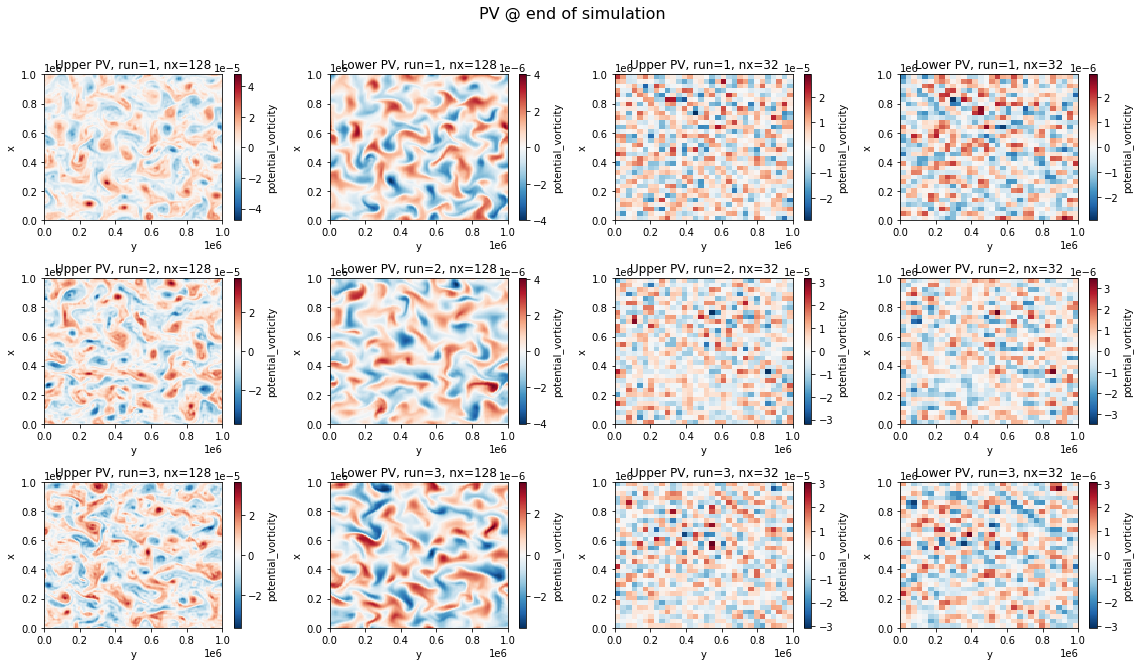

In [3]:
def z_label(z):
    return 'Lower' if z else 'Upper'
    
ns = 3
with figure_grid(ns,4,rowwidth=16) as g:
    g.title("PV @ end of simulation")
    for run in range(ns):
        for r in [r128, r32]:
            for z in [0,1]:
                r.isel(dict(run=run, time=-1, z=z)).potential_vorticity.plot(
                    ax=g.next(title=f"{z_label(z)} PV, run={run+1}, nx={r.coords['x'].size}"))

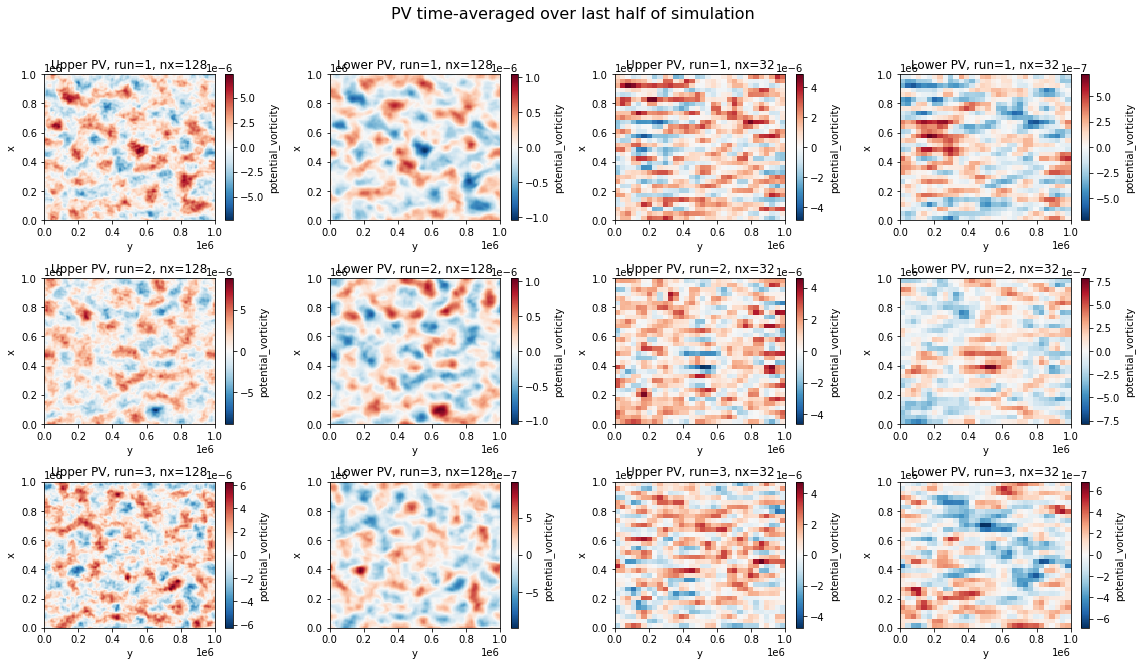

In [4]:
with figure_grid(ns,4,rowwidth=16) as g:
    g.title("PV time-averaged over last half of simulation")
    for run in range(ns):
        for r in [r128, r32]:
            nt = r.coords['time'].size
            for z in [0,1]:
                r.isel(dict(run=run, time=slice(nt//2, nt), z=z)).potential_vorticity.mean(dim=('time')).plot(
                    ax=g.next(title=f"{z_label(z)} PV, run={run+1}, nx={r.coords['x'].size}"))

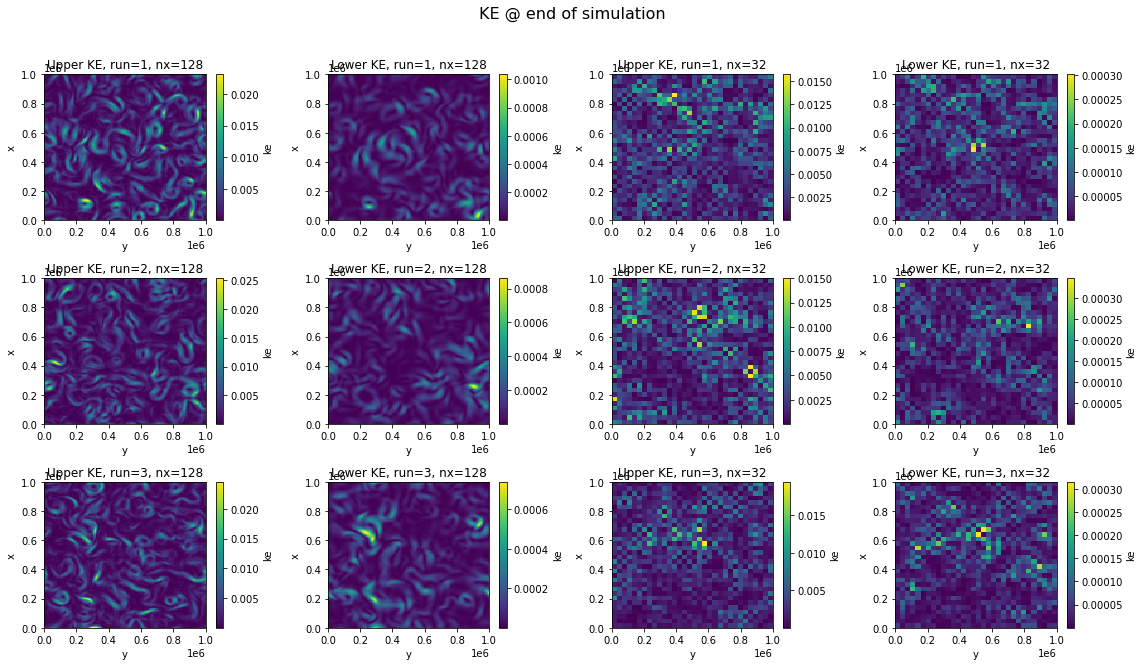

In [5]:
with figure_grid(ns,4,rowwidth=16) as g:
    g.title("KE @ end of simulation")
    for run in range(ns):
        for r in [r128, r32]:
            for z in [0,1]:
                r.isel(dict(run=run, time=-1, z=z)).ke.plot(
                    ax=g.next(title=f"{z_label(z)} KE, run={run+1}, nx={r.coords['x'].size}"))

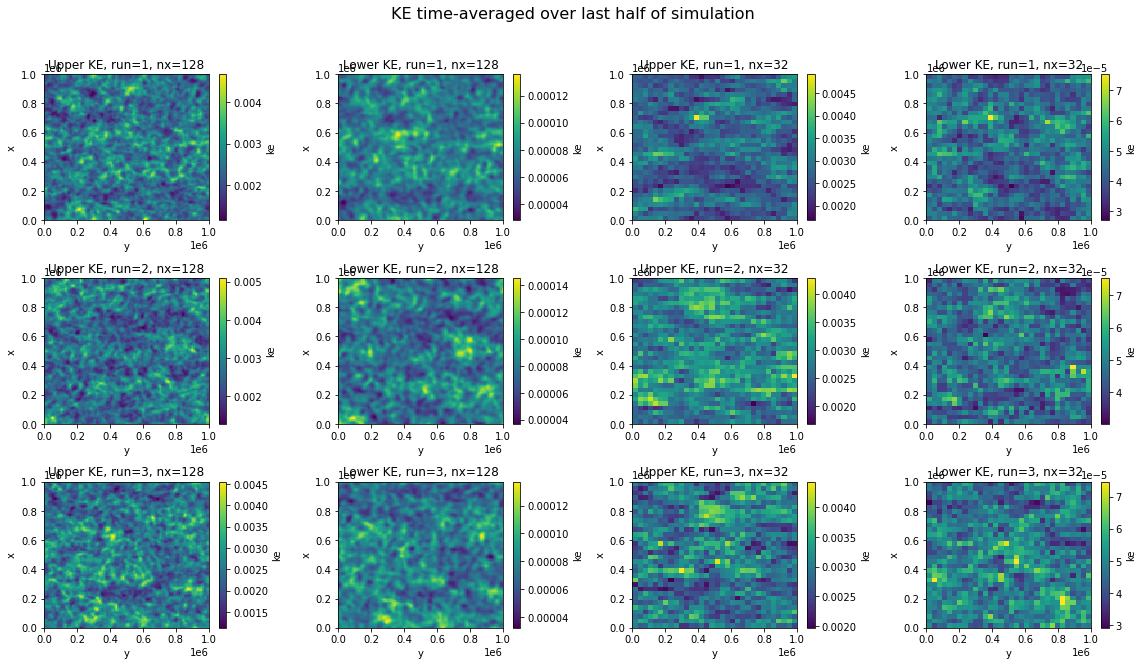

In [6]:
with figure_grid(ns,4,rowwidth=16) as g:
    g.title("KE time-averaged over last half of simulation")
    for run in range(ns):
        for r in [r128, r32]:
            nt = r.coords['time'].size
            for z in [0,1]:
                r.isel(dict(run=run, time=slice(nt//2, nt), z=z)).ke.mean(dim=('time')).plot(
                    ax=g.next(title=f"{z_label(z)} KE, run={run+1}, nx={r.coords['x'].size}"))

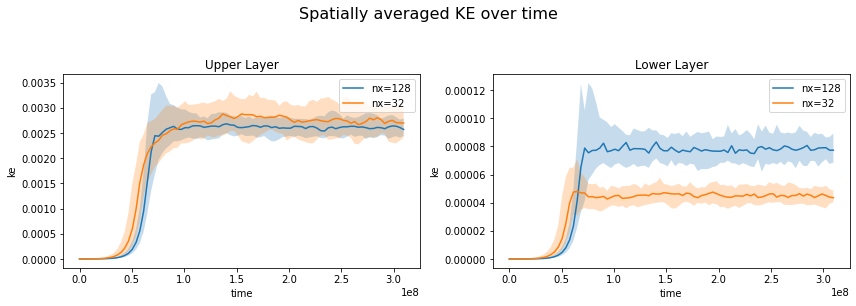

In [7]:
def spatially_averaged(q, r, z, label):
    avg = r.isel(dict(z=z))[q].mean(dim=('x','y'))
    med = avg.quantile(.5, dim='run')
    lo = avg.quantile(.05, dim='run')
    hi = avg.quantile(.95, dim='run')
    med.plot(label=label)
    plt.fill_between(avg.coords['time'], lo, hi, alpha=0.25)

with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged KE over time")
    for z in range(2):
        g.next()
        spatially_averaged('ke', r128, z, 'nx=128')
        spatially_averaged('ke', r32, z, 'nx=32')
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

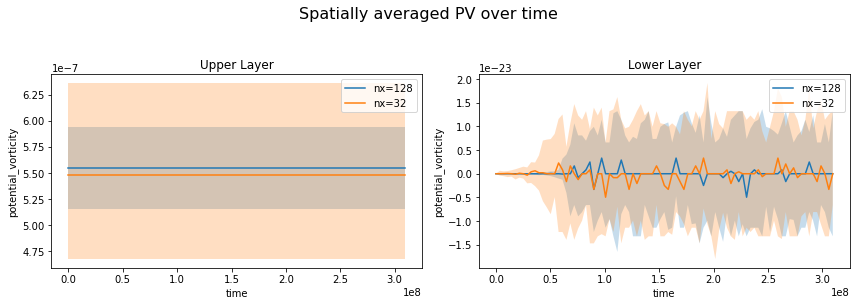

In [8]:
with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged PV over time")
    for z in range(2):
        g.next()
        spatially_averaged('potential_vorticity', r128, z, 'nx=128')
        spatially_averaged('potential_vorticity', r32, z, 'nx=32')
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

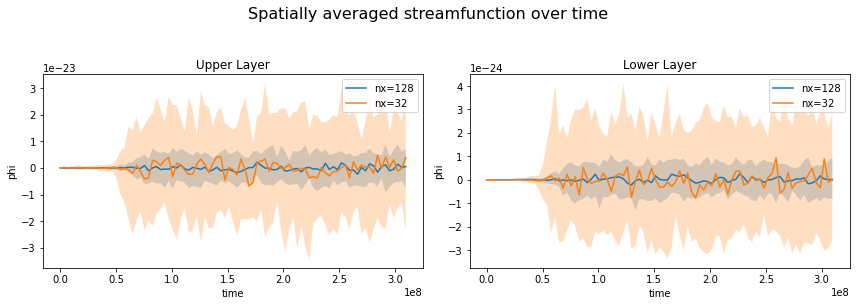

In [9]:
with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged streamfunction over time")
    for z in range(2):
        g.next()
        spatially_averaged('phi', r128, z, 'nx=128')
        spatially_averaged('phi', r32, z, 'nx=32')
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

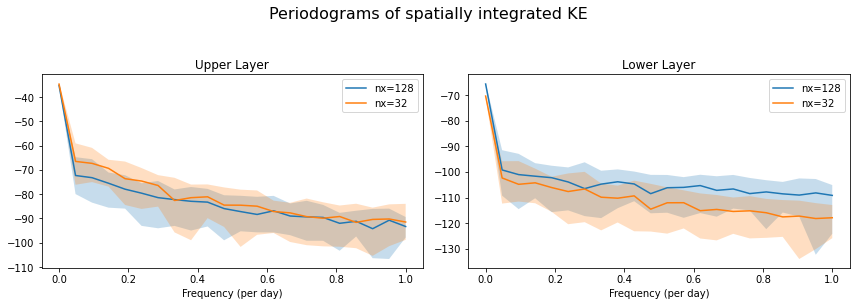

In [10]:
from numpy.fft import fft, fft2, ifft2
def periodogram_ts(ts, start = 0):
    n = ts.shape[1]
    if isinstance(start, float):
        start = int(n * start)
    n = n - start
    vals = (1 / n * abs(fft(ts[:, start: ], axis=1) ** 2))
    return [
         np.percentile(vals, pct, axis=0)[:n//2]
        for pct in [5,50,95]
    ]

def periodogram_plot(r, q, z, **kw):
    nt = r.coords['time'].size
    lo, med, hi = periodogram_ts(
        r.isel(dict(z=z))[q].mean(dim=('x','y')),
        0.5
    )
    freqs = np.linspace(0, 1, med.shape[0])
    plt.plot(freqs, 10 * np.log10(med), **kw)
    plt.fill_between(freqs, 10*np.log10(lo),10*np.log10(hi), alpha=0.25)       
    plt.xlabel("Frequency (per day)")
    
with figure_grid(1,2,rowheight=4) as g:
    g.title("Periodograms of spatially integrated KE")
    for z in [0,1]:
        g.next(title=f"{z_label(z)} Layer")
        for r in [r128, r32]:
            periodogram_plot(r, 'ke', z, label=f"nx={r.coords['x'].size}")
            plt.legend()